# Experiment with MVTecAD Transistor

Geometric transformations are simple 4 rotations here, resulting in about AUC 0.9.

- seed 1234: 0.90833
- seed 12345: 0.84438
- seed 123: 0.87271

In [1]:
from dlcliche.notebook import *
from dadgt_utils import *

deterministic_everything(1234, pytorch=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU：', device)

DATA_ROOT = Path('/data/mvtec_ad/original/transistor')

class GeoTfm4Dataset(GeoTfmDataset):
    geo_tfms = list(product(
        [None], 
        [None, Image.ROTATE_90, Image.ROTATE_180, Image.ROTATE_270],
        [None]
    ))

SIZE = 256
params = EasyDict()
params.fit = {}
params.fit.validation_split = 0.1
params.fit.lr = 0.003
params.fit.b1 = 0.95
params.fit.b2 = 0.999
params.fit.weight_decay = 0.0
params.fit.batch_size = 64
params.fit.epochs = 50
params.data = {}
params.data.load_size = SIZE + (SIZE // 50)
params.data.crop_size = SIZE
params.work_folder = 'tmp'
params.suffix = '.png'
params.project = f'Transistor-GT4-{SIZE}'
params.ds_cls = GeoTfm4Dataset
params.n_class = params.ds_cls.n_tfm()
ensure_folder(params.work_folder)

weight_file = f'{params.work_folder}/model_weights{params.project}.pth'
params

GPU： cuda:0


{'data': {'crop_size': 256, 'load_size': 261},
 'ds_cls': __main__.GeoTfm4Dataset,
 'fit': {'b1': 0.95,
  'b2': 0.999,
  'batch_size': 64,
  'epochs': 50,
  'lr': 0.003,
  'validation_split': 0.1,
  'weight_decay': 0.0},
 'n_class': 4,
 'project': 'Transistor-GT4-256',
 'suffix': '.png',
 'work_folder': 'tmp'}

In [2]:
files = sorted(DATA_ROOT.glob(f'train/good/*{params.suffix}'))
prep = PrepProject(f'dadgt-mv-{params.project}', files,
                 load_size=params.data.load_size, crop_size=params.data.crop_size, suffix=params.suffix,
                #skip_file_creation=True
                )

# Datasetを作成
train_dataset = params.ds_cls(file_list=prep.train_files, load_size=prep.load_size, crop_size=prep.crop_size,
                                transform=ImageTransform(), random=True)

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=params.fit.batch_size, shuffle=True)

# 動作の確認
batch_iterator = iter(train_dataloader)
imgs, labels = next(batch_iterator)
print(imgs.size(), labels.size(), len(train_dataset), len(train_dataloader), len(train_dataset.classes()))
del train_dataset, train_dataloader

torch.Size([64, 3, 256, 256]) torch.Size([64]) 852 14 4


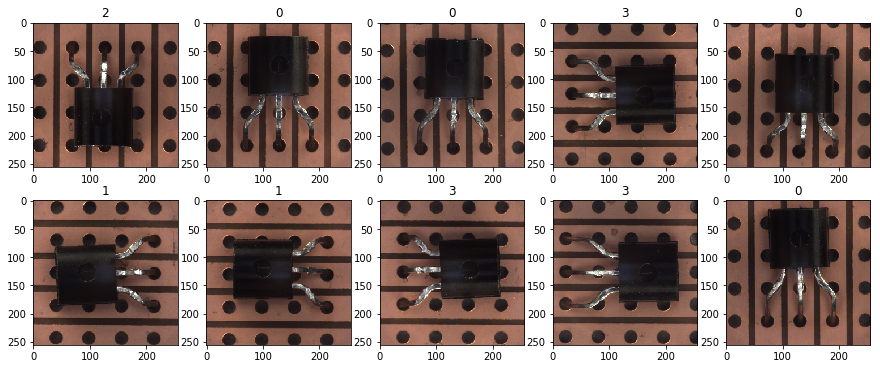

In [5]:
plt_tiled_imshow(imgs[:10], [str(l) for l in labels.detach().cpu().numpy()])

In [6]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

In [7]:
model = create_model(device, params.n_class, weight_file=None)
learner = TrainingScheme(device, model, params, prep.train_files, params.ds_cls)

trainer = pl.Trainer(max_epochs=params.fit.epochs, gpus=torch.cuda.device_count(), show_progress_bar=False)
trainer.fit(learner);

In [8]:
learner.save(weight_file)

In [11]:
org_files = sorted(DATA_ROOT.glob(f'test/*/*{params.suffix}'))
prep.prepare_test(org_files)
files = prep.test_files
labels = np.array([f.split('/')[-1].split('_')[0][:4] != 'good' for f in files])
auc, ns = GeoTfmEval.calc(device, learner, files, labels, params.n_class)
auc

0.895

In [12]:
from dlcliche.math import np_describe
np_describe(np.array(ns))

,count,mean,std,min,25%,50%,75%,max
0,100.0,0.95839,0.174824,0.000081,0.999958,0.999989,0.999993,0.999997
